In [12]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.linalg import toeplitz, solve_triangular

from Gaussian import Gaussian
from run_coverage_test import run_coverage_test, plot_coverage, plot_coverage_by_dim
from LinGaussTest import LinGaussInvProb, LinGaussTest
from helper import get_random_corr_mat
from modmcmc import State, BlockMCMCSampler, LogDensityTerm, TargetDensity
from modmcmc.kernels import MarkovKernel, GaussMetropolisKernel, DiscretePCNKernel, mvn_logpdf

# Inverse Problem Setup

Linear Gaussian inverse problem with a forward model defined as the composition of a linear convolution with a 
sub-sampling observation operator.

In [13]:
def gaussian_kernel(x, lengthscale):
    return np.exp(-0.5 * (x / lengthscale) ** 2)

def gaussian_kernel_grid(size, lengthscale):
    """
    Evaluates discrete Gaussian kernel exp(-(i/sigma)^2 / 2) at 
    `size` integers. If `size` is odd this will result in symmetry 
    about zero, otherwise it will be off by one. e.g., for `size = 3`
    the values are evaluated at -1, 0, 1. For `size = 4` evaluated 
    at -2, -1, 0, 1. The kernel values are normalized to sum to one.
    """
    x = np.arange(size) - size // 2
    kernel = np.exp(-0.5 * (x / lengthscale) ** 2)
    kernel /= kernel.sum()
    return kernel

def gaussian_cov_mat(d, lengthscale, scale):
    Sig = np.zeros((d,d))
    for i in range(d):
        for j in range(i+1):
            k = gaussian_kernel(i-j, lengthscale)
            Sig[i,j] = k
            Sig[j,i] = k
            
    return scale**2 * Sig

def linear_same_convolution(u, k_vals):
    """
    Linear convolution of `u` with `k_vals`, returning vector of same 
    length as `u`. Discrete convolution of the "same" variety.
    """

    out = np.convolve(u, k_vals, mode="full")

    # Clip so output is of length equal to `len(u)`
    start = len(k_vals) // 2
    end = start + len(u)
    return out[start:end]

def construct_toeplitz_forward_model(d, ker_vals):
    """
    Returns linear matrix G representing the forward model. This is a 
    Toeplitz matrix encoding the discrete linear convolution.
    d is the dimension of the discretized signal u, and ker_vals
    is the vector of discrete kernel evaluations.

    Returns a (d,d) Toeplitz matrix encoding a discrete linear 
    "same" convolution.
    """

    kernel_length = len(ker_vals)

    first_col = np.zeros(d)
    first_col[:kernel_length//2+1] = ker_vals[kernel_length//2::-1]
    
    first_row = np.zeros(d)
    first_row[:kernel_length//2+1] = ker_vals[kernel_length//2:]
    
    G = toeplitz(first_col, first_row)
    return G


def construct_noise_cov(G, variances):
    # Compose covariance matrix in singular basis
    U, s, Vh = np.linalg.svd(G)
    C_eps = (Vh.T * variances) @ Vh

    return C_eps
    

In [14]:
rng = np.random.default_rng(532124)

d = 100
ker_length = 21
ker_lengthscale = 20
grid = np.arange(d)

# Prior distribution
jitter = 1e-8
m0 = np.zeros(d)
C0 = gaussian_cov_mat(d, lengthscale=5, scale=1) + jitter * np.identity(d)

# Forward model (convolution with sampling)
s = 4 # every sth spatial index is observed
ker_grid = gaussian_kernel_grid(ker_length, ker_lengthscale)
G_conv = construct_toeplitz_forward_model(d, ker_grid)

idx_obs = np.arange(0, d, s)
n = len(idx_obs)
H = np.zeros((n, d), dtype=int)
H[np.arange(n), idx_obs] = 1
G = H @ G_conv

# Noise covariance
variances = np.sqrt(0.2)**2 * np.ones(n)
Sig = np.diag(variances)

In [15]:
# Inverse problem object
inv_prob = LinGaussInvProb(rng, G, m0, C0, Sig)

g_conv_true = G_conv @ inv_prob.u_true

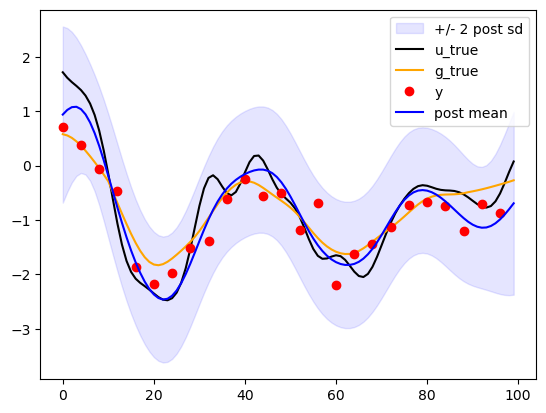

In [33]:
post_sd = np.sqrt(np.diag(inv_prob.post.cov))
ci_lower = inv_prob.post.mean - 2 * post_sd
ci_upper = inv_prob.post.mean + 2 * post_sd

plt.fill_between(grid, ci_lower, ci_upper, color='blue', alpha=0.1, label="+/- 2 post sd")
plt.plot(grid, inv_prob.u_true, color="black", label="u_true")
plt.plot(grid, g_conv_true, color="orange", label="g_true")
plt.plot(idx_obs, inv_prob.y, "o", color="red", label="y")
plt.plot(grid, inv_prob.post.mean, color="blue", label="post mean")
plt.legend()
plt.show()

In [ ]:
svd_fig = inv_prob.plot_G_singular_vals()
whitened_svd_fig = inv_prob.plot_G_singular_vals(whiten=True)

display(svd_fig)
display(whitened_svd_fig)

# Surrogate Model

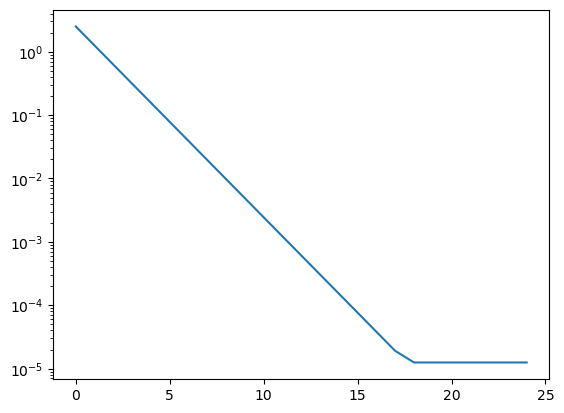

In [ ]:
# Construct Q so that trace(Q) = trace(Sig) (doubling total variance)
tr_Sig = np.trace(inv_prob.noise.cov)
q_floor = 1e-6
q_start = np.max(np.diag(inv_prob.noise.cov))
q = np.array([max(q_floor, q_start/2**i) for i in range(n)])
q_vars = tr_Sig * q / q.sum()

plt.semilogy(q_vars)
plt.show()

In [ ]:
"""
U, s, Vh = np.linalg.svd(inv_prob.G)

# High noise in stable directions
Q_stable = (U*q_vars) @ U.T

# High noise in unstable directions
Q_unstable = (U*q_vars[::-1]) @ U.T

# Noise proportional to prior pushforward
Q_prior = 0.5 * G @ inv_prob.prior.cov @ G.T

# All error in first left singular vector direction
idx = 0
u1 = U[idx,:]
eps = 1e-6
scaler = np.sum(s)
Q1 = 5 * scaler * np.linalg.outer(u1, u1) + eps * np.identity(inv_prob.n)
"""

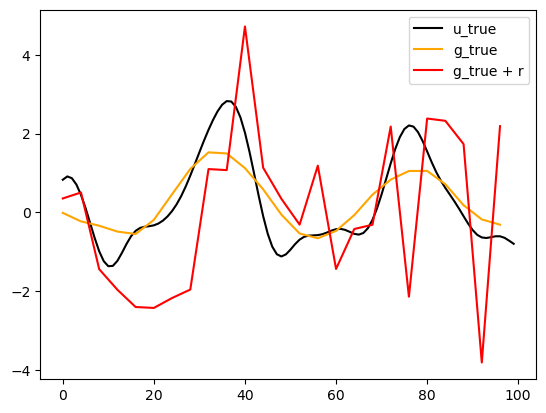

In [8]:
u_samp = inv_prob.prior.sample()
g_samp = inv_prob.G @ u_samp

r_samp = Gaussian(rng=rng, cov=Q1).sample()
g_samp_perturbed = g_samp + r_samp

plt.plot(grid, u_samp, color="black", label="u_true")
plt.plot(idx_obs, g_samp, color="orange", label="g_true")
plt.plot(idx_obs, g_samp_perturbed, color="red", label="g_true + r")
plt.legend()
plt.show()

# Run Numerical Experiments

In [21]:
n_reps = 1
n_plot_rows = int(max(1, np.ceil(d/4)))
Q = np.trace(inv_prob.noise.cov) * np.identity(inv_prob.n)

In [22]:
tests, res, probs = run_coverage_test(rng, n_reps, m0=inv_prob.prior.mean, 
                                      C0=inv_prob.prior.cov, Sig=inv_prob.noise.cov, 
                                      G=inv_prob.G, Q_true=Q, Q=Q)

Replication 1


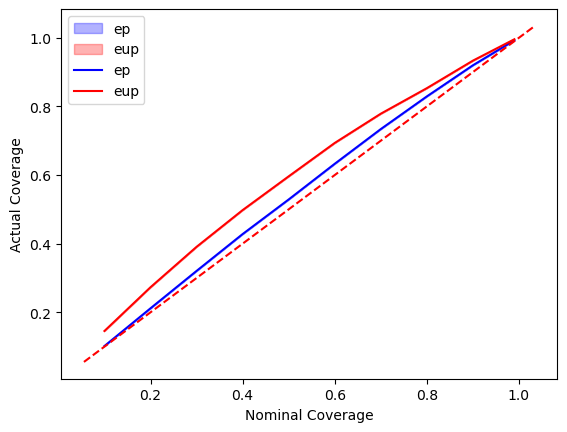

In [23]:
fig_cover, ax_cover = plot_coverage(
    ep_coverage=res['cover']['ep_cover_joint'],
    eup_coverage=res['cover']['eup_cover_joint'], 
    probs=probs, q_min=0.05, q_max=0.95
)

display(fig_cover)

## Looking at a Single Replicate

In [25]:
test_idx = 0
test = tests[test_idx]


In [27]:
print(res['mcmc']['ep_rk_w2'][test_idx])
print(res['mcmc']['ep_rkpcn90_w2'][test_idx])
print(res['mcmc']['ep_rkpcn95_w2'][test_idx])
print(res['mcmc']['ep_rkpcn99_w2'][test_idx])

70.80921884520578
7.058349936587742
6.319660024963023
4.106063893333116


In [38]:
def plot_post_summary(test, post_name, grid):
    if post_name == "exact":
        post_rv = test.post
    elif post_name == "eup":
        post_rv = test.eup_post
    elif post_name == "ep":
        post_rv = test.ep_post
    else:
        raise ValueError(f"Invalid post_name {post_name}")

    post_sd = np.sqrt(np.diag(post_rv.cov))
    ci_lower = post_rv.mean - 2 * post_sd
    ci_upper = post_rv.mean + 2 * post_sd

    plt.fill_between(grid, ci_lower, ci_upper, color='blue', alpha=0.1, label="+/- 2 post sd")
    # plt.plot(grid, inv_prob.u_true, color="black", label="u_true")
    # plt.plot(grid, g_conv_true, color="orange", label="g_true")
    plt.plot(idx_obs, test.y, "o", color="red", label="y")
    plt.plot(grid, post_rv.mean, color="blue", label="post mean")
    plt.legend()
    plt.show()

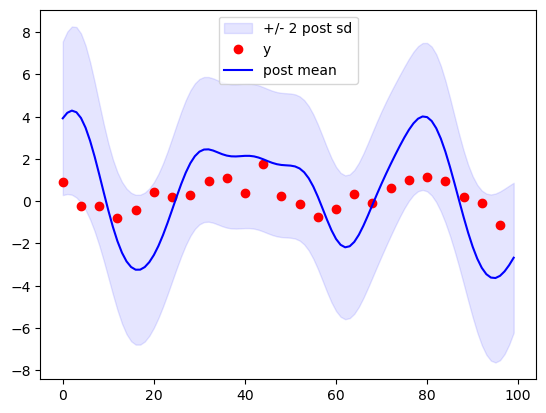

In [ ]:
plot_post_summary(test, 'ep', grid)

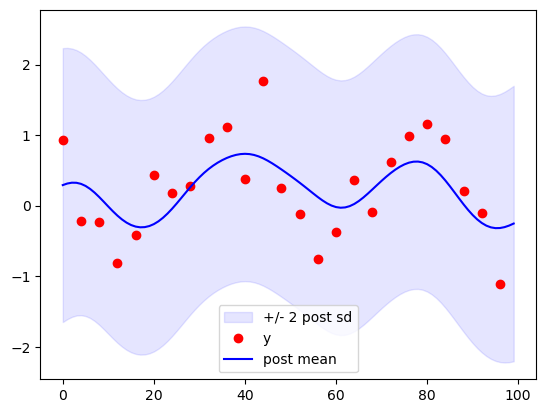

In [41]:
plot_post_summary(test, 'eup', grid)

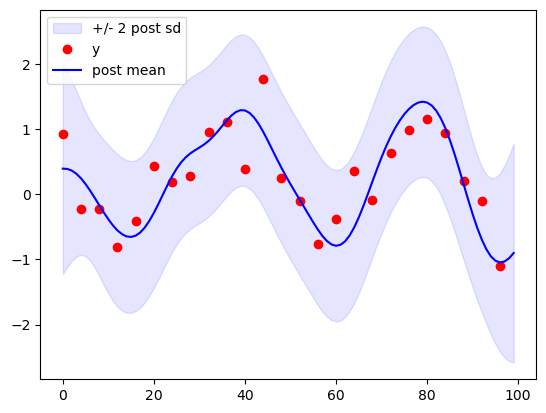

In [40]:
plot_post_summary(test, 'exact', grid)

## Scaling behavior as surrogate uncertainty grows

In [148]:
from analytical_analysis import (
    plot_eigenvalue_comparison,
    lambda_exact,
    lambda_eup,
    lambda_ep,
    alpha_exact,
    alpha_eup,
    alpha_ep,
)

In [166]:
def plot_eigenvalue_comparison(G, q_vals=None, c0=1.0, sig=1.0,
                               s_idcs=None):
    if q_vals is None:
        q_vals = np.linspace(0, 6, num=100)

    U, s, Vh = np.linalg.svd(G)
    if s_idcs is None:
        s_idcs = np.arange(0, len(s), len(s) // 3) 
    
    eig_exact = lambda_exact(s, c0=c0, sig=sig)
    eig_eup = lambda_eup(s, q_vals, c0=c0, sig=sig)
    eig_ep = lambda_ep(s, q_vals, c0=c0, sig=sig)

    eig_eup_norm = eig_eup / eig_exact
    eig_ep_norm = eig_ep / eig_exact

    fig, axs = plt.subplots(1, 2, figsize=(8,4))

    q_over_sigma = q_vals / sig

    # eup
    ax = axs[0]
    eup_eig_plot = ax.plot(q_over_sigma, eig_eup_norm[:,s_idcs])
    ax.set_title(f'eup lambdas, sigma={sig}')
    ax.set_xlabel('q / sigma')
    ax.set_ylabel('lambda eup / lambda')

    # ep
    ax = axs[1]
    ep_eig_plot = ax.plot(q_over_sigma, eig_ep_norm[:,s_idcs])
    ax.set_title(f'ep lambdas, sigma={sig}')
    ax.set_xlabel('q / sigma')
    ax.set_ylabel('lambda ep / lambda')
    ax.legend(ep_eig_plot, s_idcs)

    plt.close()
    return fig, axs

def plot_mean_comparison(G, y, r, q_vals=None, c0=1.0, sig=1.0,
                         s_idcs=None):
    if q_vals is None:
        q_vals = np.linspace(0, 6, num=100)

    U, s, Vh = np.linalg.svd(G)
    if s_idcs is None:
        s_idcs = np.arange(0, len(s), len(s) // 3)

    alphas_exact = alpha_exact(s=s, y=y, U=U, c0=c0, sig=sig)
    alphas_eup = alpha_eup(s=s, y=y, U=U, r=r, q=q_vals, c0=c0, sig=sig)
    alphas_ep = alpha_ep(s=s, y=y, U=U, r=r, q=q_vals, c0=c0, sig=sig)
    alphas_eup_norm = (alphas_eup - alphas_exact) / alphas_exact
    alphas_ep_norm = (alphas_ep - alphas_exact) / alphas_exact

    fig, axs = plt.subplots(1, 2, figsize=(8,4))
    q_over_sigma = q_vals / sig

    # eup
    ax = axs[0]
    eup_mean_plot = ax.plot(q_over_sigma, alphas_eup_norm[:,s_idcs])
    ax.set_title(f'eup alphas, r = {r}, sigma={sig}')
    ax.set_xlabel('q / sigma')
    ax.set_ylabel('relative bias')

    # ep
    ax = axs[1]
    ep_mean_plot = ax.plot(q_vals, alphas_ep_norm[:,s_idcs])
    ax.set_title(f'ep alphas, r = {r}, sigma={sig}')
    ax.set_xlabel('q / sigma')
    ax.set_ylabel('relative bias')
    ax.legend(ep_mean_plot, s_idcs)

    plt.close()
    return fig, axs

In [139]:
c0 = 1.0
r = 0
q_over_sig_max = 10.0

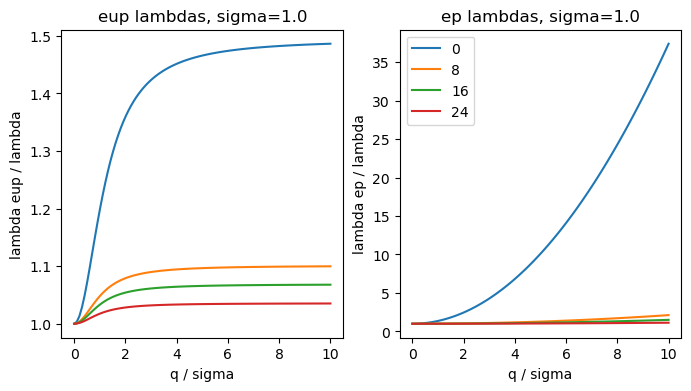

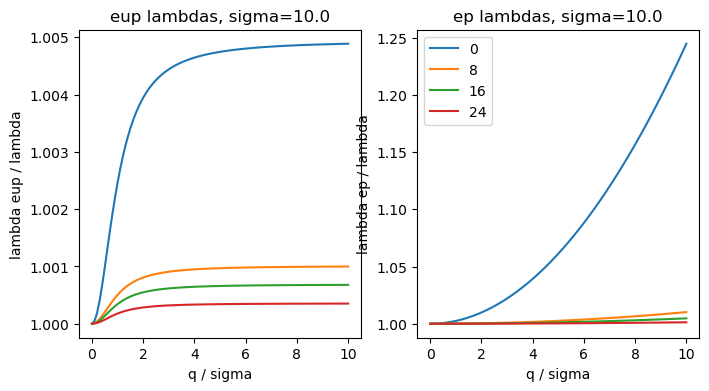

In [ ]:
# small sigma
sig = 1.0
q_vals = np.linspace(1e-16, sig * q_over_sig_max, num=100)
fig_small_sig, ax_small_sig = plot_eigenvalue_comparison(test.G, c0=c0, 
                                                         sig=sig, 
                                                         s_idcs=None, 
                                                         q_vals=q_vals)

# large sigma
sig = 10.0
q_vals = np.linspace(1e-16, sig * q_over_sig_max, num=100)
fig_big_sig, ax_big_sig = plot_eigenvalue_comparison(test.G, c0=c0, 
                                                     sig=sig, 
                                                     s_idcs=None, 
                                                     q_vals=q_vals)

display(fig_small_sig)
display(fig_big_sig)
plt.close()

In [171]:
np.abs(r / q_vals)

array([1.00000000e+17, 9.90000000e+00, 4.95000000e+00, 3.30000000e+00,
       2.47500000e+00, 1.98000000e+00, 1.65000000e+00, 1.41428571e+00,
       1.23750000e+00, 1.10000000e+00, 9.90000000e-01, 9.00000000e-01,
       8.25000000e-01, 7.61538462e-01, 7.07142857e-01, 6.60000000e-01,
       6.18750000e-01, 5.82352941e-01, 5.50000000e-01, 5.21052632e-01,
       4.95000000e-01, 4.71428571e-01, 4.50000000e-01, 4.30434783e-01,
       4.12500000e-01, 3.96000000e-01, 3.80769231e-01, 3.66666667e-01,
       3.53571429e-01, 3.41379310e-01, 3.30000000e-01, 3.19354839e-01,
       3.09375000e-01, 3.00000000e-01, 2.91176471e-01, 2.82857143e-01,
       2.75000000e-01, 2.67567568e-01, 2.60526316e-01, 2.53846154e-01,
       2.47500000e-01, 2.41463415e-01, 2.35714286e-01, 2.30232558e-01,
       2.25000000e-01, 2.20000000e-01, 2.15217391e-01, 2.10638298e-01,
       2.06250000e-01, 2.02040816e-01, 1.98000000e-01, 1.94117647e-01,
       1.90384615e-01, 1.86792453e-01, 1.83333333e-01, 1.80000000e-01,
      

/var/folders/8y/dh1rsmhx3y13wxw2h2f713qm0000gn/T/ipykernel_63703/4097341390.py:12: RuntimeWarning: divide by zero encountered in divide
  ax_mean_small_r[0].plot(q_vals/sig, np.abs(r/q_vals), color='r', linestyle='-')


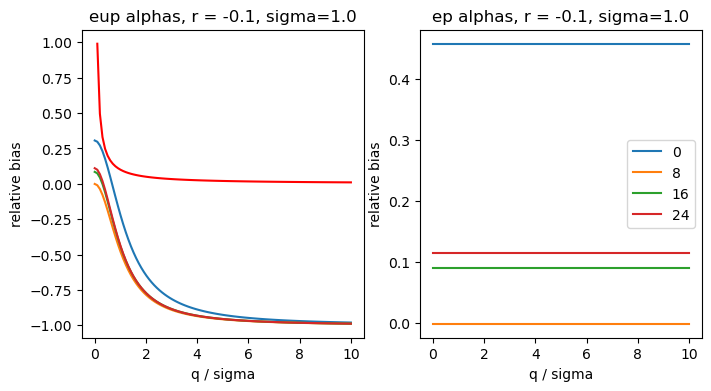

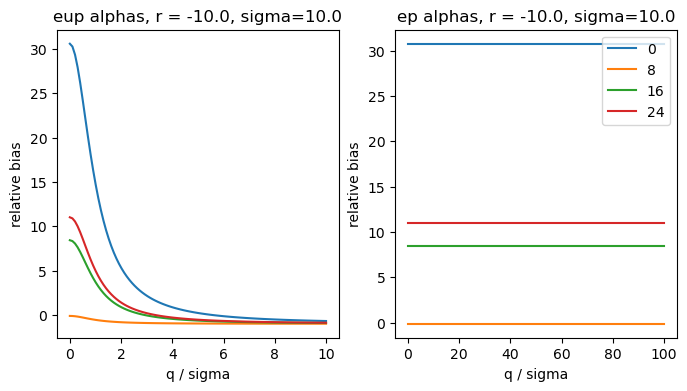

In [173]:
# TODO: some other options:
# - Fix sig and vary ratio r/q

# small bias
r = -0.1
sig = 1.0 
q_vals = np.linspace(0, sig * q_over_sig_max, num=100)
fig_mean_small_r, ax_mean_small_r = plot_mean_comparison(G=test.G, y=test.y, r=r, 
                                                         q_vals=q_vals, 
                                                         c0=c0, sig=sig,
                                                         s_idcs=None)
ax_mean_small_r[0].plot(q_vals/sig, np.abs(r/q_vals), color='r', linestyle='-')
# ax_mean_small_r[0].axvline(x=r/sig, color='r', linestyle='--')

# big bias
r = -10.0
sig = 10.0 
q_vals = np.linspace(0, sig * q_over_sig_max, num=100)
fig_mean_big_r, ax_mean_big_r = plot_mean_comparison(G=test.G, y=test.y, r=r, 
                                                     q_vals=q_vals, 
                                                     c0=c0, sig=sig,
                                                     s_idcs=None)

display(fig_mean_small_r)
display(fig_mean_big_r)

In [159]:
# Fixing ratio r/q [so emulator is always calibrated] and varying 
# q/sigma.

sig = 1.0 
r_over_q = 1.0
q_vals = np.linspace(1e-16, sig * q_over_sig_max, num=100)
r_vals = q_vals.copy()
nq = len(q_vals)
nr = nq

In [160]:
U, s, Vh = np.linalg.svd(G)
ns = len(s)
s_idcs = np.arange(0, len(s), len(s) // 3)
y = test.y.copy()

alphas_exact = alpha_exact(s=s, y=y, U=U, c0=c0, sig=sig)
alphas_eup_norm = np.empty((nr, nq, ns))
alphas_ep_norm = np.empty((nr, nq, ns))

for i, r in enumerate(r_vals):
    alphas_eup = alpha_eup(s=s, y=y, U=U, r=r, q=q_vals, c0=c0, sig=sig)
    alphas_ep = alpha_ep(s=s, y=y, U=U, r=r, q=q_vals, c0=c0, sig=sig)
    alphas_eup_norm[i] = alphas_eup - alphas_exact
    alphas_ep_norm[i] = alphas_ep - alphas_exact



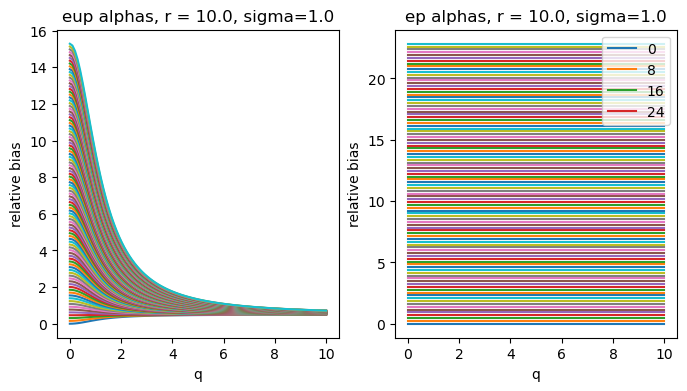

In [161]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
q_over_sigma = q_vals / sig

# eup
ax = axs[0]
eup_mean_plot = ax.plot(q_over_sigma, alphas_eup_norm[...,0].T)
ax.set_title(f'eup alphas, r = {r}, sigma={sig}')
ax.set_xlabel('q')
ax.set_ylabel('relative bias')

# ep
ax = axs[1]
ep_mean_plot = ax.plot(q_vals, alphas_ep_norm[...,0].T)
ax.set_title(f'ep alphas, r = {r}, sigma={sig}')
ax.set_xlabel('q')
ax.set_ylabel('relative bias')
ax.legend(ep_mean_plot, s_idcs)

plt.close()

display(fig)